In [167]:
import pandas as pd
import yaml
from sqlalchemy import create_engine

with open('/Users/adamidris/Coding/morocco-house-prediction/config/db_creds.yaml') as f:
    creds = yaml.safe_load(f)
    
user = creds['DB_USER']
password = creds['DB_PASS']
host = creds['DB_HOST']
port = creds['DB_PORT']
database = creds['DB_NAME']

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")
df = pd.read_sql_table('properties_for_rent', engine.connect())

In [168]:
df = df.dropna(subset='price')
df['price'] = df['price'].astype(int)
df.drop(columns=['date_published', 'scraped_at', 'id'], inplace=True)
df.describe()

df.price.quantile(0.95)

np.float64(40000.0)

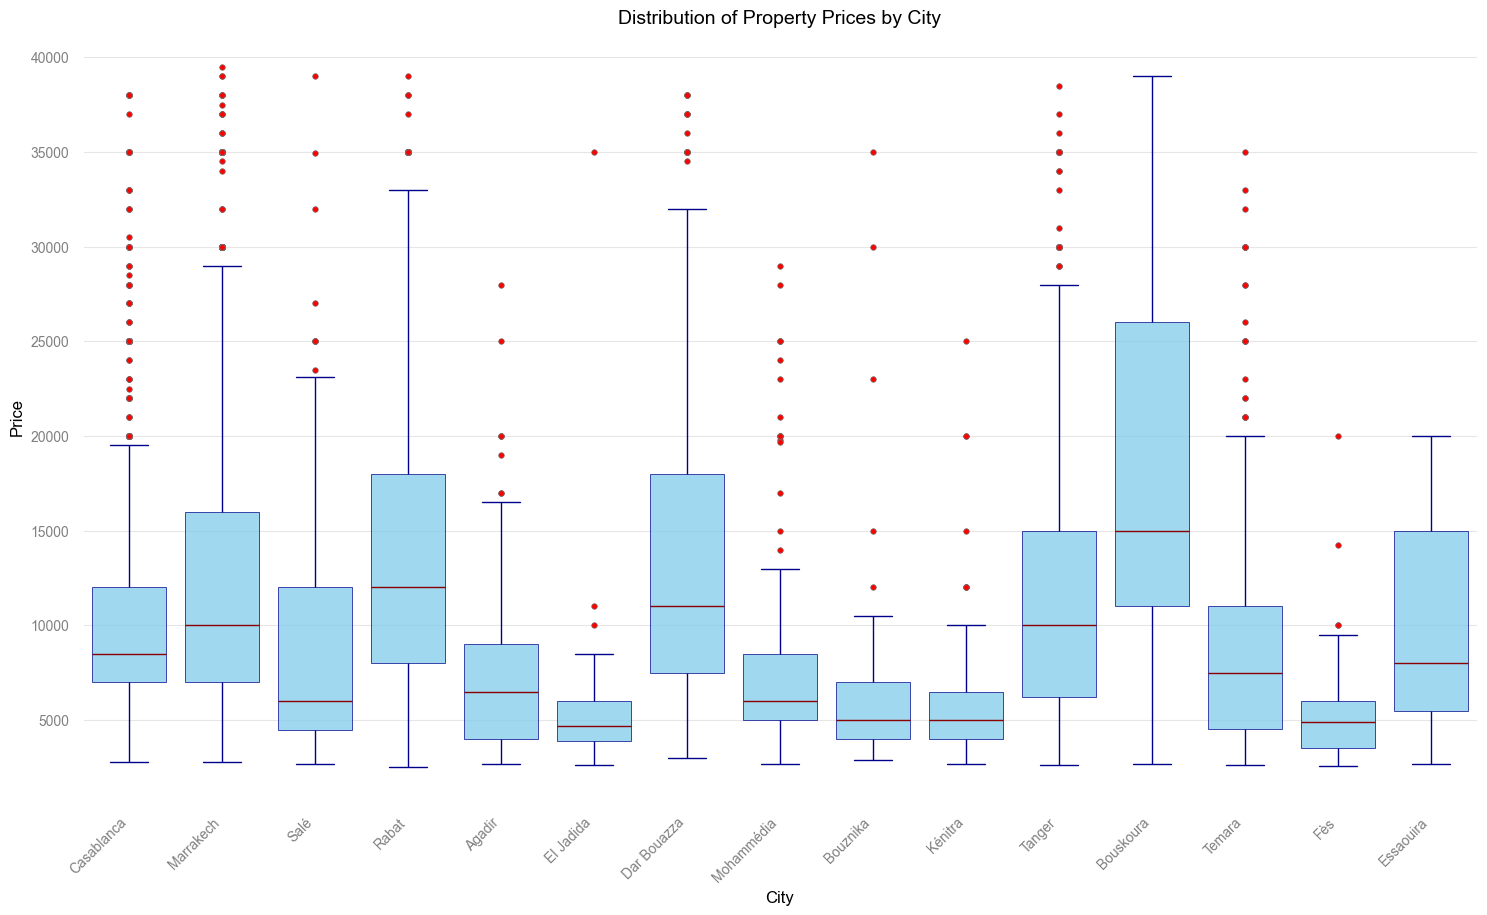

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

pop_cities = list(df.city.value_counts()[:15].index)
pop_cities_df = df[df['city'].isin(pop_cities)]
pop_cities_df = pop_cities_df[(pop_cities_df['price'] < 40000) & (pop_cities_df['price'] > 2500)]
sns.set_style("whitegrid", {"grid.color": ".9"})

sns.set_context("notebook", font_scale=0.9, rc={"grid.linewidth": 0.8})

# Plot
fig = plt.figure(figsize=(18, 10))
sns.boxplot(x='city', y='price', data=pop_cities_df, 
            color='skyblue', 
            boxprops=dict(facecolor=(0.53, 0.81, 0.92, 0.8), edgecolor="darkblue", linewidth=0.5),
            whiskerprops=dict(color="darkblue"),
            capprops=dict(color="darkblue"),
            medianprops=dict(color="darkred", linewidth=1),
            flierprops=dict(marker='o', color='red', markersize=4, markerfacecolor='red', markeredgewidth=0.5))

# Customizing the plot
plt.title("Distribution of Property Prices by City", fontsize=14, color="black")
plt.xlabel("City", fontsize=12, color="black")
plt.ylabel("Price", fontsize=12, color="black")
plt.xticks(rotation=45, ha='right', fontsize=10, color="grey")
plt.yticks(fontsize=10, color="grey")

for spine in plt.gca().spines.values():
    spine.set_color("white")  
    spine.set_linewidth(1.5)    

plt.show()

In [175]:
pop_cities_df = pop_cities_df[pop_cities_df['size'] < 300]

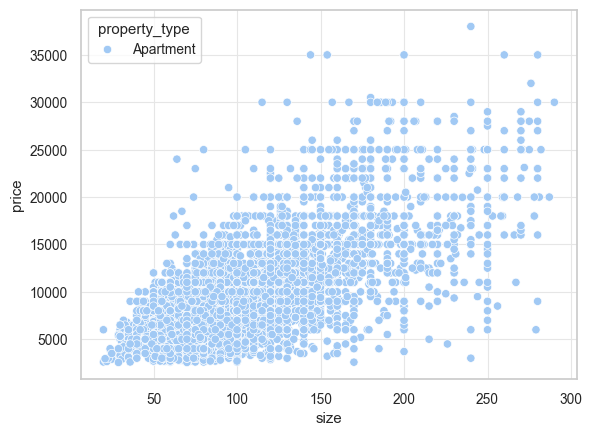

In [177]:
import numpy as np

sns.scatterplot(x='size', y='price', data=pop_cities_df[pop_cities_df['property_type'] == 'Apartment'], hue='property_type')
plt.show()

<Axes: xlabel='price', ylabel='Count'>

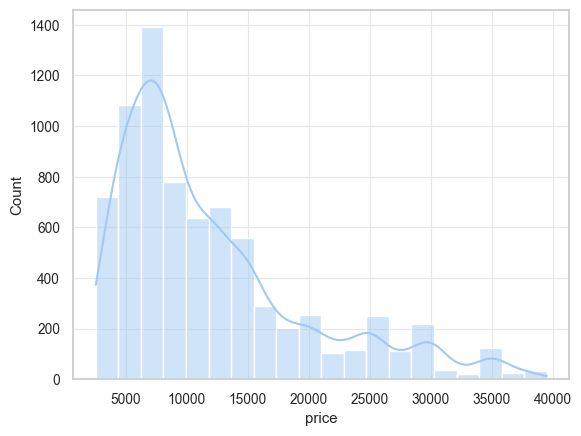

In [186]:
sns.histplot(pop_cities_df['price'], bins=20, kde=True)